# Procedural Python for Reproducibility

The goal today is to take some of the ideas we developed last week, and do a couple things to make our lives easier:

- Define standalone functions which accomplish tasks that we would like to do repeatedly
- Put these functions in a place where we can easily use them without copy-pasting repeatedly
- Think about how to make our analysis reproducible – both for the sake of our future selves, and for the sake of anyone who wants to replicate and/or build on our work.

To that end, we are going to work together to do the following tasks:

1. Write a function which will download the Pronto data and the weather data

   - This function should **only** download the data if it isn't already present on disk
   - Pronto data can be downloaded at https://data.seattle.gov/api/views/tw7j-dfaw/rows.csv?accessType=DOWNLOAD
   - Weather data can be downloaded at http://uwseds.github.io/data/pronto_weather.csv
   
2. Write two functions which, given the downloaded data, will load it, parse dates properly, and return a pandas array.
   
3. Write a function which will group and join the trip and weather data into a single DataFrame, making use of the above functions.
   
4. Develop some plots showing relationships in the data, and write a function which will create and save plots related to your analysis.

   - Number of rides per day over the course of the year (day-pass and annual members)
   - Number of rides per hour over the course of the day (day-pass and annual members)
   - Number of rides per day as a function of temperature (day-pass and annual members)
   
5. Write a master script that you – or anyone – can run, which will produce your analysis from scratch.

Today during the class time we will walk through accomplishing these tasks together.

---

We ended up creating a file that looks like this:

```python
# pronto_utils.py

from urllib import request
import os
import pandas as pd


TRIP_DATA = "https://data.seattle.gov/api/views/tw7j-dfaw/rows.csv?accessType=DOWNLOAD"
TRIP_FILE = "pronto_trips.csv"

WEATHER_DATA = "http://uwseds.github.io/data/pronto_weather.csv"
WEATHER_FILE = "pronto_weather.csv"

def download_if_not_present(url, filename):
    """Download file from URL to filename
    If filename is present, then skip download.
    """
    if os.path.exists(filename):
        print("File already present")
    else:
        print("Downloading", filename)
        request.urlretrieve(url, filename)
        
def download_trips():
    """Download the pronto trip data unless already downloaded"""
    download_if_not_present(TRIP_DATA, TRIP_FILE)
    
def download_weather():
    download_if_not_present(WEATHER_DATA, WEATHER_FILE)
    
def load_weather_data():
    download_weather()
    return pd.read_csv('pronto_weather.csv',
                       parse_dates=['DATE'],
                       index_col='DATE')

def load_trip_data():
    download_trips()
    data = pd.read_csv('pronto_trips.csv')
    data['starttime'] = pd.to_datetime(data['starttime'], format="%m/%d/%Y %I:%M:%S %p")
    data['stoptime'] = pd.to_datetime(data['stoptime'], format="%m/%d/%Y %I:%M:%S %p")
    data['tripminutes'] = data['tripduration'] / 60
    return data


def join_trips_and_weather():
    """Group trips by day and join with the daily weather data
    Returns: pandas DataFrame
    """
    weather = load_weather_data()
    trips = load_trip_data()
    tripdates = pd.DatetimeIndex(trips['starttime']).date
    trips_by_day = pd.pivot_table(trips,
                                  values='trip_id',
                                  index=tripdates,
                                  columns='usertype',
                                  aggfunc='count')
    return trips_by_day.join(weather)
```

---

And here is how we used it:

In [1]:
import pronto_utils

In [2]:
weather = pronto_utils.load_weather_data()
trips = pronto_utils.load_trip_data()

File already present
File already present


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

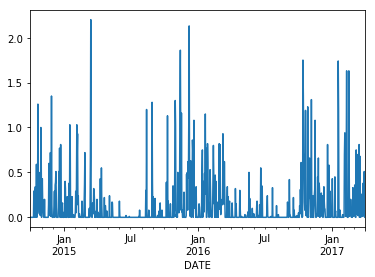

In [4]:
weather['PRECIPITATION_INCHES'].plot()

In [5]:
joined_data = pronto_utils.join_trips_and_weather()

File already present
File already present


In [6]:
joined_data.columns

Index(['Member', 'Short-Term Pass Holder', 'PRECIPITATION_INCHES',
       'MIN_TEMPERATURE_F', 'MAX_TEMPERATURE_F', 'AVG_TEMPERATURE_F',
       'AVG_WIND_SPEED_MPH', 'SNOWFALL_INCHES', 'FOG', 'HEAVY_FOG', 'THUNDER',
       'HAIL', 'SMOKE'],
      dtype='object')

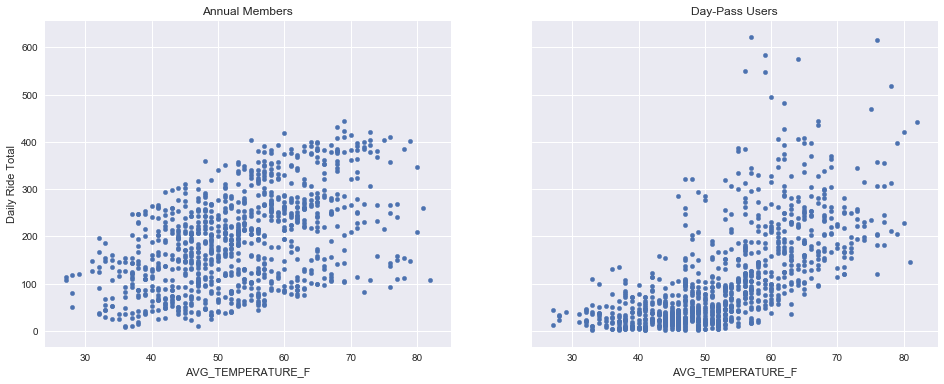

In [7]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True, sharex=True)
joined_data.plot.scatter('AVG_TEMPERATURE_F', 'Member', ax=ax[0])
joined_data.plot.scatter('AVG_TEMPERATURE_F', 'Short-Term Pass Holder', ax=ax[1])

ax[0].set_title("Annual Members")
ax[1].set_title("Day-Pass Users")
ax[0].set_ylabel("Daily Ride Total")

fig.savefig('rides_vs_temperature.png')